In [1]:
# -*- coding: utf-8 -*-

"""
This software is part of GPU Ocean. 
Copyright (C) 2019 SINTEF Digital

This python program is used to set up and run a data-assimilation 
and drift trajectory forecasting experiment.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
"""


import sys, os, json, datetime, time, shutil
import numpy as np

current_dir = os.getcwd()

if os.path.isdir(os.path.abspath(os.path.join(current_dir, '../../SWESimulators'))):
        sys.path.insert(0, os.path.abspath(os.path.join(current_dir, '../../')))

In [2]:
#--------------------------------------------------------------
# PARAMETERS
#--------------------------------------------------------------
ensemble_size = 10
method = "iewpf2"
observation_interval = 1
observation_variance = 1.0
observation_type = "bouys"
buoy_area = "all"
media_dir = "forecasting_results/"

num_days = 7
num_hours = 24
forecast_days = 3
profiling = "store_true"


In [3]:
###-----------------------------------------
## Define files for ensemble and truth.
##
ensemble_init_path = 'C:/Users/florianb/Documents/GPU-Ocean/data/ensemble_init/'
assert len(os.listdir(ensemble_init_path)) == 100 or len(os.listdir(ensemble_init_path)) == 101, \
    "Ensemble init folder has wrong number of files: " + str(len(os.listdir(ensemble_init_path)))

truth_path = 'C:/Users/florianb/Documents/GPU-Ocean/data/true_state/'
assert len(os.listdir(truth_path)) == 2 or len(os.listdir(truth_path)) == 3, \
    "Truth folder has wrong number of files"


timestamp = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
destination_dir = os.path.join(media_dir, "da_experiment_" +  timestamp + "/")
os.makedirs(destination_dir)

# Copy the truth into the destination folder
shutil.copytree(truth_path, os.path.join(destination_dir, 'truth'))

# Define misc filenames
log_file = os.path.join(destination_dir, 'description.txt')

particleInfoPrefix = os.path.join(destination_dir, 'particle_info_')
forecastFileBase = os.path.join(destination_dir, 'forecast_member_')


with open(log_file, 'w') as f:
    f.write('Data Assimilation experiment ' + timestamp + '\n')
    f.write('----------------------------------------------' + '\n')

def logParams():
    log('Input arguments:')
    #for arg in vars(args):
    #    log('\t' + str((arg, getattr(args, arg))))
    log('\nPath to initial conditions for ensemble:')
    log('\t' + ensemble_init_path)
    log('Path to true state:')
    log('\t' + truth_path)
    log('destination folder:')
    log('\t' + destination_dir)
    log('Path to particle info:')
    log('\t' + particleInfoPrefix)
    log('Path to forecast members:')
    log('\t' + forecastFileBase)

def log(msg, screen=True):
    with open(log_file, 'a') as f:
        f.write(msg + '\n')
    if screen:
        print(msg)
        
logParams()
        
    
# Reading and checking method
method = str(method).lower()
if method == 'iewpf2':
    log(' ----> Using IEWPF 2 stage method')
elif method == 'none':
    log(' ----> No data assimilation')
else:
    log('Illegal method: ' + str(method))
    sys.exit(-1)
    
    
# Time parameters
start_time      =  3*24*60*60 #  3 days
simulation_time = 10*24*60*60 # 10 days (three days spin up is prior to this)fa
end_time        = 13*24*60*60 # 13 days


# Based on truth from June 25th 2019
#drifterSet = [ 2, 7, 12, 24, 29, 35, 41, 48, 53, 60]
drifterSet = [ 2, 24, 60]

# Log extra information for the ensemble state for the following cells:
extraCells = np.array([[254, 241], # Cross with two trajectories
                       [249, 246], # northwest of above
                       [259, 236], # southeast of above
                       [343, 131], # Closed circle of same drifter
                       [196,  245], # Middle of single trajectory
                       [150,  250], # Middle of single trajectory, later than above
                       [102, 252], # On the same trajectory as the above, but later, and also in a intersection
                       [ 388, 100], # Unobserved area just north of southern jet
                       [ 388, 80],  # Unobserved area in southern jet
                       [ 388, 150], # Unobserved area in calm area
                      ])

Input arguments:

Path to initial conditions for ensemble:
	C:/Users/florianb/Documents/GPU-Ocean/data/ensemble_init/
Path to true state:
	C:/Users/florianb/Documents/GPU-Ocean/data/true_state/
destination folder:
	forecasting_results/da_experiment_2020_11_23-09_43_24/
Path to particle info:
	forecasting_results/da_experiment_2020_11_23-09_43_24/particle_info_
Path to forecast members:
	forecasting_results/da_experiment_2020_11_23-09_43_24/forecast_member_
 ----> Using IEWPF 2 stage method


In [4]:
###--------------------------------
# Import required packages
#
tic = time.time()
# For GPU contex:
from SWESimulators import Common
# For the ensemble:
from SWESimulators import EnsembleFromFiles, Observation
# For data assimilation:
from SWESimulators import IEWPFOcean
# For forcasting:
from SWESimulators import GPUDrifterCollection
# For ObservationType:
from SWESimulators import DataAssimilationUtils as dautils

toc = time.time()
log("\n{:02.4f} s: ".format(toc-tic) + 'GPU Ocean packages imported', True)

# Create CUDA context
tic = time.time()
gpu_ctx = Common.CUDAContext()
device_name = gpu_ctx.cuda_device.name()
toc = time.time()
log("{:02.4f} s: ".format(toc-tic) + "Created context on " + device_name, True)


1.5919 s: GPU Ocean packages imported
0.1145 s: Created context on Quadro T2000


In [5]:
###--------------------------
# Initiate the ensemble
#

observation_type = dautils.ObservationType.UnderlyingFlow
if observation_type == 'buoys':
    observation_type = dautils.ObservationType.StaticBuoys
    log('Observation type changed to StaticBuoys!')
elif observation_type == 'all_drifters':
    drifterSet = 'all'
    log('Using all drifters for DA experiment')

    
cont_write_netcdf = True and not profiling

tic = time.time()
ensemble = EnsembleFromFiles.EnsembleFromFiles(gpu_ctx, ensemble_size, \
                                               ensemble_init_path, truth_path, \
                                               observation_variance,
                                               cont_write_netcdf = cont_write_netcdf,
                                               use_lcg = True,
                                               write_netcdf_directory = destination_dir,
                                               observation_type=observation_type)

In [6]:
# Configure observations according to the selected drifters:
ensemble.configureObservations(drifterSet=drifterSet, 
                               observationInterval = observation_interval,
                               buoy_area = buoy_area)
ensemble.configureParticleInfos(extraCells)
toc = time.time()
log("{:02.4f} s: ".format(toc-tic) + "Ensemble is loaded and created", True)
log("Using drifterSet:\n" + str(drifterSet))
if observation_type == 'buoys':
    log('buoys to read:')
    log(str(ensemble.observations.read_buoy))


0.6367 s: Ensemble is loaded and created
Using drifterSet:
[2, 24, 60]


In [7]:
### -------------------------------
# Initialize IEWPF class (if needed)
#
tic = time.time()
iewpf = None
if method.startswith('iewpf'):
    iewpf = IEWPFOcean.IEWPFOcean(ensemble)
    toc = time.time()
    log("{:02.4f} s: ".format(toc-tic) + "Data assimilation class initiated", True)
else:
    toc = time.time()
    log("{:02.4f} s: ".format(toc-tic) + "Skipping creation of IEWPF as the method is not used", True)

    

    

0.0620 s: Data assimilation class initiated


In [8]:

### ----------------------------------------------
#   DATA ASSIMILATION
#

obstime = 3*24*60*60

master_tic = time.time()

numDays = num_days 
numHours = num_hours 
forecast_days = forecast_days


log('---------- Starting simulation --------------') 
log('--- numDays:       ' + str(numDays))
log('--- numHours:      ' + str(numHours))
log('--- forecast_days: ' + str(forecast_days))
log('---------------------------------------------') 


---------- Starting simulation --------------
--- numDays:       7
--- numHours:      24
--- forecast_days: 3
---------------------------------------------


In [9]:
drifter_cells = ensemble.getDrifterCells()

for minute in range(5):
    obstime += 60
    ensemble.stepToObservation(obstime, model_error_final_step=(minute<4))

    if minute == 4:
        iewpf.iewpf_2stage(ensemble, perform_step=False)

    ensemble.registerStateSample(drifter_cells)

In [10]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation, rc

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size':16})
rc('text', usetex=True)
rc('xtick', labelsize=14)     
rc('ytick', labelsize=14)
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'


def createInnovationPlot(drifter_position, true_velocity, particle_velocity, innovation, particle_velocity_pre=None, innovation_pre=None):

    print("drifter_position", drifter_position)
    print("true_velocity", true_velocity)
    print("particle_velocity", particle_velocity)
    print("innovation: ", innovation)

    cell_id_x = int(np.floor(drifter_position[0]/ensemble.dx))
    cell_id_y = int(np.floor(drifter_position[1]/ensemble.dy))
    print("cell_id: ", (cell_id_x, cell_id_y))

    fig = plt.figure(figsize=(4,4))
    ax = plt.subplot(111)
    ax.imshow(np.zeros((ensemble.ny, ensemble.nx))*np.nan, origin="lower")

    circ = matplotlib.patches.Circle((cell_id_x, cell_id_y), 2, fill=False)
    ax.add_patch(circ)

    # Add observed particle and truth
    arrow_scale = 2

    if particle_velocity_pre is None:
        particle_arrow = matplotlib.pyplot.arrow(cell_id_x, cell_id_y, 
                                                    particle_velocity[0]*arrow_scale, 
                                                    particle_velocity[1]*arrow_scale, \
                                                    color='xkcd:electric pink', width=0.7)
    else:
        particle_arrow_pre = matplotlib.pyplot.arrow(cell_id_x, cell_id_y, 
                                                    particle_velocity_pre[0]*arrow_scale, 
                                                    particle_velocity_pre[1]*arrow_scale, \
                                                    color='xkcd:electric pink', width=0.7, alpha=0.2)
        particle_arrow = matplotlib.pyplot.arrow(cell_id_x, cell_id_y, 
                                                    particle_velocity[0]*arrow_scale, 
                                                    particle_velocity[1]*arrow_scale, \
                                                    color='xkcd:electric pink', width=0.7)
        
    ax.add_patch(particle_arrow)

    truth_arrow = matplotlib.pyplot.arrow(cell_id_x, cell_id_y, 
                                            true_velocity[0]*arrow_scale, 
                                            true_velocity[1]*arrow_scale, \
                                            color='xkcd:azure', width=0.7)
    ax.add_patch(truth_arrow)

    if innovation_pre is None:
        innovation_arrow = matplotlib.pyplot.arrow(cell_id_x, #+particle_velocity[0]*arrow_scale, 
                                                    cell_id_y, #+particle_velocity[1]*arrow_scale, 
                                                    innovation[0]*arrow_scale, 
                                                    innovation[1]*arrow_scale, 
                                                    #linestyle=':',
                                                    color='xkcd:dark slate blue', width=0.7)
    else:
        innovation_arrow_pew = matplotlib.pyplot.arrow(cell_id_x, #+particle_velocity[0]*arrow_scale, 
                                                    cell_id_y, #+particle_velocity[1]*arrow_scale, 
                                                    innovation_pre[0]*arrow_scale, 
                                                    innovation_pre[1]*arrow_scale, 
                                                    #linestyle=':', 
                                                    alpha=0.2,
                                                    color='xkcd:dark slate blue', width=0.7)

        innovation_arrow = matplotlib.pyplot.arrow(cell_id_x, #+particle_velocity[0]*arrow_scale, 
                                                    cell_id_y, #+particle_velocity[1]*arrow_scale, 
                                                    innovation[0]*arrow_scale, 
                                                    innovation[1]*arrow_scale, 
                                                    #linestyle=':',
                                                    color='xkcd:dark slate blue', width=0.7)

        
    ax.add_patch(innovation_arrow)

    text_observation = plt.text(cell_id_x+true_velocity[0]*arrow_scale-10, 
                                cell_id_y+true_velocity[1]*arrow_scale+5, 
                                r'$y^n$', fontsize=15)

    if particle_velocity_pre is None:
        text_particle = plt.text(cell_id_x+particle_velocity[0]*arrow_scale-15, 
                                    cell_id_y+particle_velocity[1]*arrow_scale-10, 
                                    r'$H(\psi^{n,f})$', fontsize=15)
    else:
        # Same position as in if
        text_particle = plt.text(cell_id_x+particle_velocity_pre[0]*arrow_scale-15, 
                                    cell_id_y+particle_velocity_pre[1]*arrow_scale-10, 
                                    r'$H(\psi^{n,f})$', fontsize=15, alpha=0.4)
        text_particle = plt.text(cell_id_x+particle_velocity[0]*arrow_scale-32, 
                                    cell_id_y+particle_velocity[1]*arrow_scale-2, 
                                    r'$H(\psi^{n,a})$', fontsize=15)
        
    if innovation_pre is None:
        text_innovation = plt.text(cell_id_x+innovation[0]*arrow_scale-40, 
                                    cell_id_y+innovation[1]*arrow_scale+5, 
                                    r'$d^n = y^n - H(\psi^{n,f})$', fontsize=15)
    else:
        # Same position as in if
        text_innovation = plt.text(cell_id_x+innovation_pre[0]*arrow_scale-40, 
                                    cell_id_y+innovation_pre[1]*arrow_scale+5, 
                                    r'$d^n = y^n - H(\psi^{n,f})$', fontsize=15, alpha=0.4)
        text_innovation = plt.text(cell_id_x+innovation[0]*arrow_scale-25, 
                                    cell_id_y+innovation[1]*arrow_scale-15, 
                                    r'$d^n = y^n - H(\psi^{n,a})$', fontsize=15)
        

    #ax.annotate('', xy=(1.2, 0.3), xycoords='axes fraction', xytext=(1.1, 0.4), 
    #        arrowprops=dict(arrowstyle="->", color='green'))
    #fig.canvas.draw()

    axis_label = plt.text(-ensemble.nx/7, -ensemble.ny/7, r'$\Omega^M$', fontsize=15)

    plt.title('Observation, particle state and innovation', fontsize=15)

    return ax


drifter_position [ 69322.69 291361.12]
true_velocity [-40.2216918  -10.28171899]
particle_velocity [-12.76976681  25.81879044]
innovation:  [-27.04554657 -35.99662844]
cell_id:  (31, 131)


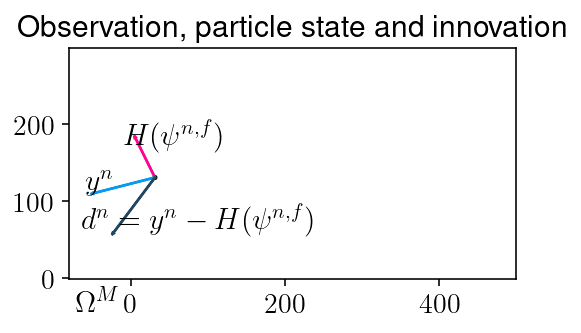

In [11]:

drifter_id  = 1
particle_id = 0

drifter_position = ensemble.observeTrueDrifters()[drifter_id,:]
true_velocity = ensemble.observeTrueState()[drifter_id,2:]
particle_velocity = ensemble.observeParticles()[particle_id,drifter_id,:]
innovation = ensemble.getInnovations()[particle_id,drifter_id,:]

innovation_pre=None
particle_velocity_pre=None

ax = createInnovationPlot(drifter_position, true_velocity, particle_velocity, innovation)

# Step-By-Step EnKF in Square Root Formulation

## Calculate $S = H X'_f$

In [12]:
"""
Particles are observed in the following form:
[
particle 1:  [hu_1, hv_1], ... , [hu_D, hv_D],
...
particle Ne: [hu_1, hv_1], ... , [hu_D, hv_D]
]

In order to bring it in accordance with later data structure we use the following format for the storage of the perturbation of the observation:
[
[hu_1 (particle 1), ..., hu_1 (particle Ne)],
...
[hu_D (particle 1), ..., hu_D (particle Ne)],
[hv_1 (particle 1), ..., hv_1 (particle Ne)],
...
[hv_D (particle 1), ..., hv_D (particle Ne)],
]

"""

# Number of observers
n_D = len(drifterSet)

# Observation 
HX_f_orig = ensemble.observeParticles()

# Reshaping
HX_f = np.zeros( (2*n_D, ensemble_size) )
for e in range(ensemble_size):
    for l in range(n_D):
        HX_f[l,e]     = HX_f_orig[e,l,0]
    for l in range(n_D):
        HX_f[n_D+l,e] = HX_f_orig[e,l,1]

HX_f_mean = np.zeros_like(HX_f)
for e in range(ensemble_size):
    HX_f_mean = 1/ensemble_size * HX_f[:,e]

HX_f_pert = HX_f - HX_f_mean.reshape((2*n_D,1))



## Calculate $SS^\top = HPH^\top$ 

In [13]:

HPHT = 1/(ensemble_size-1) * np.dot(HX_f_pert,HX_f_pert.T)


## Calculate $F = HPH^\top + R$

In [14]:
R_orig = ensemble.getObservationCov() * 0.01

R = np.zeros( (R_orig.shape[0]*n_D, R_orig.shape[1]*n_D) )

for l in range(n_D):
    R[l,l] = R_orig[0,0]
    R[n_D+l, n_D+l] = R_orig[1,1]
    R[l,n_D+l] = R_orig[0,1]
    R[n_D+l,l] = R_orig[1,0]

F = HPHT + R

## Calculate Innovation $D = Y - HX_f$ 
## and perturb $D=D+Y'$

In [15]:
"""
Particles yield innovations in the following form:
[
particle 1:  [hu_1, hv_1], ... , [hu_D, hv_D],
...
particle Ne: [hu_1, hv_1], ... , [hu_D, hv_D]
]

In order to bring it in accordance with later data structure we use the following format for the storage of the perturbation of the observation:
[
[d_hu_1 (particle 1), ..., d_hu_1 (particle Ne)],
...
[d_hu_D (particle 1), ..., d_hu_D (particle Ne)],
[d_hv_1 (particle 1), ..., d_hv_1 (particle Ne)],
...
[d_hv_D (particle 1), ..., d_hv_D (particle Ne)],
]

"""

innovation_orig = ensemble.getInnovations()[:,:,:]

# Reshaping
innovation = np.zeros( (2*n_D, ensemble_size) )
for e in range(ensemble_size):
    for l in range(n_D):
        innovation[l,e]     = innovation_orig[e,l,0]
    for l in range(n_D):
        innovation[n_D+l,e] = innovation_orig[e,l,1]

Y_pert = np.random.multivariate_normal(np.zeros(2*len(drifterSet)),R ,10).T

D = innovation + Y_pert


## Calculate $C = F^{-1}D$

In [16]:
Finv = np.linalg.inv(F)
C = np.dot(Finv,D)

## Calculate $E=S^\top C$


In [17]:
E = np.dot(HX_f_pert.T,C)

## Calculate $X'_f = X_f - \overline{X_f}$ 

In [18]:
"""
The download gives eta = 
[
[eta(x0,y0),...,eta(xN,y0)],
...,
[eta(x0,yN),...,eta(xN,yN)]
]
as an array of size Ny x Nx
and analog for hu and hv.
we use those as an 1D array eta = 
[eta(x0,y0),...,eta(xN,y0),eta(x0,y1),...,eta(xN,y(N-1)),eta(x0,yN),...,eta(xN,yN)]
and anlog for hu and hv 

For further calculations the indivdual dimensions of the state variable are concatinated X = 
[eta, hu, hv]

Collecting the state perturbation for each ensemble member in a matrix Nx x Ne, where
X_f_pert = 
[ 
[eta_pert(x0,y0) (particle 1),..., eta_pert],
...
particle 2: [eta_pert,hu_pert,hv_pert]
]
"""

# Ghost cells added 
n_i = ensemble.particles[0].ny + 4 
n_j = ensemble.particles[0].nx + 4

X_f = np.zeros((3*n_i*n_j, ensemble_size))
for e in range(ensemble_size):
    eta, hu, hv = ensemble.particles[e].download(interior_domain_only=False)
    eta = eta.reshape(n_i*n_j)
    hu  = hu.reshape(n_i*n_j)
    hv  = hv.reshape(n_i*n_j)
    X_f[:,e] = np.append(eta, np.append(hu,hv))

X_f_mean = np.zeros( 3*n_i*n_j )
for e in range(ensemble_size):
    X_f_mean += 1/ensemble_size * X_f[:,e]

X_f_pert = np.zeros_like( X_f )
for e in range(ensemble_size):
    X_f_pert[:,e] = X_f[:,e] - X_f_mean
 

## Calculate $X_a$


In [19]:
X_a = X_f + 1/(ensemble_size-1) * np.dot(X_f_pert,E)

## Reshape and upload analysis state

In [24]:
for e in range(ensemble_size):
    eta = X_a[0:n_i*n_j, e].reshape((n_i,n_j))
    eta = np.zeros((n_i,n_j))
    hu  = X_a[n_i*n_j:2*n_i*n_j, e].reshape((n_i,n_j))
    hu = np.zeros((n_i,n_j))
    hv  = X_a[2*n_i*n_j:3*n_i*n_j, e].reshape((n_i,n_j))
    hv = np.zeros((n_i,n_j))
    ensemble.particles[e].upload(eta,hu,hv)


drifter_position [ 69322.69 291361.12]
true_velocity [-40.2216918  -10.28171899]
particle_velocity [0. 0.]
innovation:  [-40.2216918  -10.28171899]
cell_id:  (31, 131)


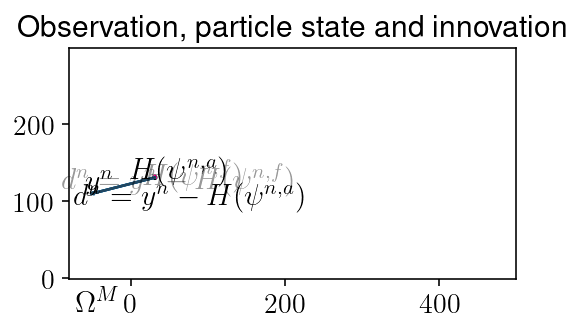

In [27]:

drifter_position_pre = drifter_position
particle_velocity_pre = particle_velocity
innovation_pre = innovation

drifter_position = ensemble.observeTrueDrifters()[drifter_id,:]
true_velocity = ensemble.observeTrueState()[drifter_id,2:]
particle_velocity = ensemble.observeParticles()[particle_id,drifter_id,:]
innovation = ensemble.getInnovations()[particle_id,drifter_id,:]

ax = createInnovationPlot(drifter_position, true_velocity, particle_velocity, innovation, particle_velocity_pre, innovation_pre)

In [30]:
for e in range(ensemble_size):
    eta = X_f[0:n_i*n_j, e].reshape((n_i,n_j))
    hu  = X_f[n_i*n_j:2*n_i*n_j, e].reshape((n_i,n_j))
    hv  = X_f[2*n_i*n_j:3*n_i*n_j, e].reshape((n_i,n_j))
    ensemble.particles[e].upload(eta,hu,hv)

drifter_position_f   = ensemble.observeTrueDrifters()[drifter_id,:]
true_velocity_f      = ensemble.observeTrueState()[drifter_id,2:]
particle_velocity_f  = ensemble.observeParticles()[particle_id,drifter_id,:]
innovation_f         = ensemble.getInnovations()[particle_id,drifter_id,:]


for e in range(ensemble_size):
    eta = X_a[0:n_i*n_j, e].reshape((n_i,n_j))
    hu  = X_a[n_i*n_j:2*n_i*n_j, e].reshape((n_i,n_j))
    hv  = X_a[2*n_i*n_j:3*n_i*n_j, e].reshape((n_i,n_j))
    ensemble.particles[e].upload(eta,hu,hv)

drifter_position_a   = ensemble.observeTrueDrifters()[drifter_id,:]
true_velocity_a      = ensemble.observeTrueState()[drifter_id,2:]
particle_velocity_a  = ensemble.observeParticles()[particle_id,drifter_id,:]
innovation_a         = ensemble.getInnovations()[particle_id,drifter_id,:]

print("drifter_postion = ", drifter_position_f, " vs ", drifter_position_a)
print("true_velocity = ", true_velocity_f, " vs ", true_velocity_a)
print("particle_velocity = ", particle_velocity_f, " vs ", particle_velocity_a)
print("innovation = ", innovation_f, " vs ", innovation_a)

drifter_postion =  [ 69322.69 291361.12]  vs  [ 69322.69 291361.12]
true_velocity =  [-40.2216918  -10.28171899]  vs  [-40.2216918  -10.28171899]
particle_velocity =  [-12.76976681  25.81879044]  vs  [-34.52289581 -13.0010891 ]
innovation =  [-27.04554657 -35.99662844]  vs  [-5.28453491  2.8252661 ]


In [ ]:
from importlib import reload

from SWESimulators import CDKLM16, BaseOceanStateEnsemble, PlotHelper

# DEFINE PARAMETERS

sim_args = {
    "gpu_ctx": gpu_ctx,
    "nx": 120, "ny": 120,
    #"nx": 15, "ny": 15,
    "dx": 4.0, "dy": 4.0,
    "dt": 0.05,
    "g": 9.81,
    "f": 0.05,
    "coriolis_beta": 0.0,
    "r": 0.0,
    "rk_order": 2,
    "small_scale_perturbation_amplitude": None,
    "write_netcdf": False, 
    "small_scale_perturbation": True,
    "small_scale_perturbation_interpolation_factor": 5,
    "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
}

ghosts = np.array([2,2,2,2]) # north, east, south, west
validDomain = np.array([2,2,2,2])


dataShape = (sim_args["ny"] + ghosts[0]+ghosts[2], 
             sim_args["nx"] + ghosts[1]+ghosts[3])
dataShapeHi = (sim_args["ny"] + ghosts[0]+ghosts[2]+1, 
             sim_args["nx"] + ghosts[1]+ghosts[3]+1)

sim_args["eta0"] = np.zeros(dataShape, dtype=np.float32, order='C');
sim_args["hv0"] = np.zeros(dataShape, dtype=np.float32, order='C');
sim_args["hu0"] = np.zeros(dataShape, dtype=np.float32, order='C');
waterDepth = 10.0
sim_args["H"] = np.ones(dataShapeHi, dtype=np.float32, order='C')*waterDepth


if 'sim' in globals(): 
    sim.cleanUp()
if 'ensemble' in globals():
    ensemble.cleanUp()
if 'iewpfOcean' in globals():
    iewpfOcean.cleanUp()
    
sim_args["small_scale_perturbation_amplitude"] = np.sqrt(sim_args["dt"])*0.5*sim_args["f"]/(sim_args["g"]*waterDepth)
sim_args["small_scale_perturbation_amplitude"] *= sim_args["small_scale_perturbation_interpolation_factor"]
print ("q0: ", sim_args["small_scale_perturbation_amplitude"])
print ("[f, g, H, dt]", [sim_args["f"], sim_args["g"], waterDepth, sim_args["dt"]])
print ("(nx, ny): ", (sim_args["nx"], sim_args["ny"]))

reload(CDKLM16)
reload(BaseOceanStateEnsemble)
reload(OceanNoiseEnsemble)
reload(PlotHelper)
reload(dautils)
reload(IEWPFOcean)

sim = CDKLM16.CDKLM16(**sim_args)

In [ ]:
from SWESimulators import OceanNoiseEnsemble

ensemble_args = {
    "gpu_ctx": gpu_ctx,
    "numParticles": 5,
    "num_drifters": 1,
    "sim": sim,
    "observation_type": dautils.ObservationType.DirectUnderlyingFlow,
    "observation_variance": 0.015**2 #0.02**2
}

ensemble = OceanNoiseEnsemble.OceanNoiseEnsemble(**ensemble_args)
ensemble.plotEnsemble()